In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv
/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv


In [2]:
data = pd.read_csv('/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv')
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
data = data.drop(["id"], axis=1)
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [4]:
data['length'] = data['tweet'].apply(len)
data.head()

,label,tweet,length
0,0,@user when a father is dysfunctional and is s...,102
1,0,@user @user thanks for #lyft credit i can't us...,122
2,0,bihday your majesty,21
3,0,#model i love u take with u all the time in ...,86
4,0,factsguide: society now #motivation,39


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
 2   length  31962 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [6]:
data.isnull().sum()

label     0
tweet     0
length    0
dtype: int64

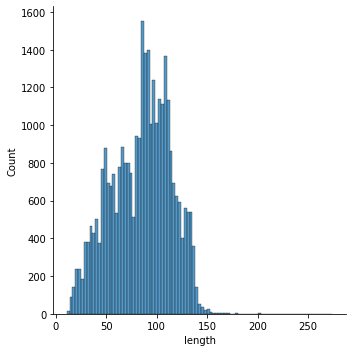

In [7]:
import seaborn as sns 

sns.displot(data['length'])

data preprocessing

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [9]:
# remove the stop words 

stop = stopwords.words('english')

def remove_stop_words(df):
    df['stop_words'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
    print(df[['tweet', 'stop_words']].head())
remove_stop_words(data)

                                               tweet  stop_words
0   @user when a father is dysfunctional and is s...          10
1  @user @user thanks for #lyft credit i can't us...           5
2                                bihday your majesty           1
3  #model   i love u take with u all the time in ...           5
4             factsguide: society now    #motivation           1


In [10]:
#remove the punctuation 

def remove_punctuation(df):
    df['tweet'] = df['tweet'].str.replace('[^\w\s]', ' ')
    print(df['tweet'].head())
remove_punctuation(data)

0      user when a father is dysfunctional and is s...
1     user  user thanks for  lyft credit i can t us...
2                                  bihday your majesty
3     model   i love u take with u all the time in ...
4               factsguide  society now     motivation
Name: tweet, dtype: object


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [11]:
#remove the most frequest words and rare words 
freq = pd.Series(''.join(data['tweet']).split()).value_counts()[:12]
freq = list(freq.index) 

def remove_freq_words(df):
    df['tweet'] = df['tweet'].apply(lambda x : ' '.join(x for x in x.split() if x not in freq))
    print(df['tweet'])
    
remove_freq_words(data)

0        when father is dysfunctional is so selfish he ...
1        thanks lyft credit can t use cause they don t ...
2                                      bihday your majesty
3                    model love u take with u all time urð
4                        factsguide society now motivation
                               ...                        
31957                                 ate isz that youuu ï
31958    see nina turner on airwaves trying wrap hersel...
31959    listening sad songs on monday morning otw work...
31960      sikh temple vandalised calgary wso condemns act
31961                                         thank follow
Name: tweet, Length: 31962, dtype: object


In [12]:
#remove the most rare words and rare words 
rare = pd.Series(''.join(data['tweet']).split()).value_counts()[-12:]
rare 

def remove_rare_words(df):
    df['tweet'] = df['tweet'].apply(lambda x : ' '.join(x for x in x.split() if x not in rare))
    print(df['tweet'])
    
remove_rare_words(data)

0        when father is dysfunctional is so selfish he ...
1        thanks lyft credit can t use cause they don t ...
2                                      bihday your majesty
3                    model love u take with u all time urð
4                        factsguide society now motivation
                               ...                        
31957                                 ate isz that youuu ï
31958    see nina turner on airwaves trying wrap hersel...
31959    listening sad songs on monday morning otw work...
31960      sikh temple vandalised calgary wso condemns act
31961                                         thank follow
Name: tweet, Length: 31962, dtype: object


In [13]:
freq

['user', 'ð', 'the', 'to', 'i', 'a', 'you', 'and', 'in', 'for', 'â', 'of']

In [14]:
#stemming 

stemmer = PorterStemmer()

corpus =[]
for i in range(len(data)):
    review = re.sub('[^a-zA-Z]', ' ',str(data['tweet'][i]))
    review = review.lower()
    review = review.split()
    review = [stemmer.stem(i) for i in review if not i in set(stopwords.words('english'))] 
    review = ' '.join(review)
    corpus.append(review) 

In [15]:
# creating Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(corpus).toarray()
y = data['label']

In [16]:
#split the train and test data
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

In [17]:
xtrain.shape, ytrain.shape

((25569, 31303), (25569,))

In [18]:
xtest.shape, ytest.shape

((6393, 31303), (6393,))

In [19]:
# training the naive bayes model
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(xtrain, ytrain)

MultinomialNB()

In [20]:
y_pred = mnb.predict(xtest)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
#confusion matrix 
from sklearn.metrics import confusion_matrix, accuracy_score
confusion_matrix(y_pred, ytest)

array([[5985,  362],
       [   0,   46]])

In [22]:
accuracy_score(y_pred, ytest)

0.9433755670264352